<a href="https://colab.research.google.com/github/NULabTMN/ps2-PoojaKShanbhag/blob/master/SequencePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Prediction: Surname Generation

In this experiment, you will explore a simple sequence prediction task: Text generation using a Gated Recurrent Unit (GRU). Like the LSTM, this is a  gated recurrent neural network, but since it has fewer parameters, it should be more appropriate for a smaller dataset.

The GRU computes a probability distribution over the set of possible characters in the surname vocabulary for each time step. We use these probability distributions to generate new surnames. You are given a starter code, that trains a SurnameGenerationModel on the [surname dataset](https://github.com/jasoriya/CS6120-PS2-support/blob/master/data/surnames/surnames_with_splits.csv) to generate new surnames by learning from the training data. 



Your task is to understand this code and plot the over all perplxity of GRU model as a function of the hidden representation size (K) and the number of characters already observed. You will see **TODO** prompts in the following cells

## Imports

In [0]:
import os
from argparse import Namespace

import numpy as np
import httpimport
import torch
import torch.optim as optim
from tqdm import tqdm_notebook

# import data preprocessing and modeling functions from https://github.com/jasoriya/CS6120-PS2-support/tree/master/utils
with httpimport.remote_repo(['data_vectorization','model','helper'], 'https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/utils/'):
    from data_vectorization import Vocabulary, SequenceVocabulary, SurnameVectorizer, SurnameDataset, generate_batches
    from model import SurnameGenerationModel, sample_from_model, decode_samples
    from helper import make_train_state, update_train_state, normalize_sizes, compute_accuracy, sequence_loss, set_seed_everywhere, handle_dirs


In [0]:
rnn = [2,4,7,10,14,18]
k = 0

### Settings and some prep work

**TODO**: 
- Give path to a directory where the model should be saved
- Give hidden state size (`rnn_hidden_size`) for the GRU model (experiment with different levels)


In [0]:
args = Namespace(
    # Data and Path information
    surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir= "./model", # give path here
    # Model hyper parameters
    char_embedding_size=32,
    rnn_hidden_size= rnn[k], # give hidden size
    # Training hyper parameters
    seed=1337,
    learning_rate=0.001,
    batch_size=128,
    num_epochs=100,
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	./model\vectorizer.json
	./model\model.pth
Using CUDA: True


### Initializations

In [0]:
# Data set load, create vectoizer and instantiate the model
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()
print("vectorizer.char_vocab",len(vectorizer.char_vocab))
print("vectorizer.char_vocab.mask_index", vectorizer.char_vocab.mask_index)
model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

vectorizer.char_vocab 88
vectorizer.char_vocab.mask_index 0


### Training loop

In [0]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)

# allows dynamic learning rate reducing based on some validation measurements. 
#optimizer (Optimizer) – Wrapped optimizer.
#mode (str) – One of min, max. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; in max mode it will be reduced when the quantity monitored has stopped increasing. Default: ‘min’.
#factor (python:float) – Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
#patience (python:int) – Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: 10.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

# uses model_state_file and learning_rate from args.  
#            {'stop_early': False,
#             'early_stopping_step': 0,
#             'early_stopping_best_val': 1e8,
#             'learning_rate': args.learning_rate,
#             'epoch_index': 0,
#             'train_loss': [],
#             'train_acc': [],
#             'val_loss': [],
#             'val_acc': [],
#             'test_loss': -1,
#             'test_acc': -1,
#             'model_filename': args.model_state_file}
train_state = make_train_state(args)


epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        
        # A generator function which wraps the PyTorch DataLoader. 
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        # This is for val set
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()
            
        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)
        
        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()
        
        #This is val
        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)
        
        # at epoch 0, we save the first model and set 'early_stop' to false. Other epochs, it checks if loss of current is greater than
        # loss of t-1 step. If true, it increments 'early_stop_step' by 1. Else, we check if current loss is less than 'early_stopping_best_val'
        # If true, we save the model and update "early_stopping_best_val" to current loss. We reset the 'early_stop_step' to 0.
        # If 'early_stop_step' is greater or equal to 'args.early_stopping_criteria' then we set 'early stop' to true.
        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        # move model to cpu for sampling
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, num_samples=2), 
            vectorizer)
        epoch_bar.set_postfix(sample1=sampled_surnames[0], 
                              sample2=sampled_surnames[1])
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

C:\Users\pooja\Anaconda3\envs\python36cudaPytorch\lib\site-packages\ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\pooja\Anaconda3\envs\python36cudaPytorch\lib\site-packages\ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\pooja\Anaconda3\envs\python36cudaPytorch\lib\site-packages\ipykernel_launcher.py:46: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [0]:
np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)

array([8, 7])

In [0]:
# compute the loss & accuracy on the test set using the best available model

model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.
running_loss = 0.
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
   
    y_pred = model(x_in=batch_dict['x_data'])
  #  print("x ",batch_dict['x_data'])
#     if batch_index ==0:
#         print("y shape",y_pred.shape)
#         print("x shape",batch_dict['x_data'].shape)
#         print("target shape",batch_dict['y_target'].shape)
    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # compute the accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 
#print(train_state['test_loss'])

**TODO**: Write code to compute the perplexity of the whole text corpus, the accuracy of a character-prediction task, and the perplexity at a given character position (1, 2, 3, ...).

In [0]:
print("Test loss: {};".format(train_state['test_loss']))
test_perplexity = 2**train_state['test_loss']
print("Test perplexity: {};".format(test_perplexity)) # compute and print perplexity here
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.6624450286229453;
Test perplexity: 6.331051049742199;
Test Accuracy: 22.837545954563577


In [0]:
# perplexity of whole text corpus
avg_perplexity = ((2**train_state['train_loss'][-1])+(2**train_state['val_loss'][-1])+test_perplexity)/3
avg_perplexity

6.321520440008357

In [0]:
torch.save(model, args.save_dir+'/model'+str(k))
k = k + 1


### Re run from 3rd cell


## Inference
To see the names that the model generates:

In [0]:
# number of names to generate
num_names = 10
model = model.cpu()
# Generate nationality hidden state
sampled_surnames = decode_samples(
    sample_from_model(model, vectorizer, num_samples=num_names), 
    vectorizer)
# Show results
print ("-"*15)
for i in range(num_names):
    print (sampled_surnames[i])

---------------
Ancey
Gasana
Rimdelmue
Daadorf
Jaud
San
Jinnvanle
Bkellalovsn
Sabgsae
Neim


**TODO**: Train the GRU model given above multiple times for different levels of `rnn_hidden_size`. For each of these models, plot the average perplexity as a function of the number of characters of the name observed so far. Explain your observations.

In [0]:
# calculating perplexity at each character
# compute the loss & accuracy on the test set using the best available model
allAvgPerplexities = []
def calcAvgPerp(model):
#     model.load_state_dict(torch.load(train_state['model_filename']))

    model = model.to(args.device)

    dataset.set_split('test')
    batch_generator = generate_batches(dataset, 
                                       batch_size=1, 
                                       device=args.device)
    running_acc = 0.
    running_loss = 0.
    model.eval()
    perplexityForTest = []
    for batch_index, batch_dict in enumerate(batch_generator):
        # compute the output
        x_char_data = torch.zeros(1,19, dtype=torch.int64)
        y_char_target = torch.zeros(1,19, dtype=torch.int64)
        #print(batch_dict['x_data'])
        perplexityList = []
        for i in range(19):
            x_char_data[0][i] = batch_dict['x_data'][0][i]
            y_char_target[0][i] = batch_dict['y_target'][0][i]
            #print(x_char_data)
            y_char_pred = model(x_in=x_char_data.cuda())
            #print(y_char_pred.shape)

            #compute the loss
            loss = sequence_loss(y_char_pred, y_char_target.cuda(), mask_index)
            #compute the accuracy
           # running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_char_pred, y_char_target.cuda(), mask_index)

           # print("running loss",running_loss)
            perp = (2** loss.item())
            perplexityList.append(perp)
       # print("perp list", len(perplexityList))
        perplexityForTest.append(perplexityList)
    np_array = np.array(perplexityForTest)
    lenOfTest =  len(perplexityForTest)
    avg_char_perp = np.sum(np_array, axis = 0)/lenOfTest
    print(avg_char_perp)
    allAvgPerplexities.append(avg_char_perp)
    #print(perplexityForTest)

In [0]:
for i in range(0,6):
    string = args.save_dir+'/model'+str(i)
    print(string)
    saved_model = torch.load(string)
    saved_model.eval()
    calcAvgPerp(saved_model)

./model/model0
[17.37272405 11.82713449 11.10412584 10.56842598 10.08135855  9.72933657
  9.38303612  9.12002692  8.98881544  8.94029818  8.86472873  8.88902497
  8.87279712  8.85019467  8.81162542  8.87470885  8.84900886  8.87423956
  8.80123374]
./model/model1
[14.42983426  8.80957217  9.01418106  8.99673882  8.71063011  8.55357791
  8.25776338  8.08069232  7.99572939  7.89556938  7.88562288  7.80609977
  7.78572896  7.86541779  7.83131112  7.80594427  7.8247896   7.80978994
  7.85694064]
./model/model2
[12.87730763  8.2470531   8.29445014  8.38392222  8.1492791   7.91395378
  7.66591839  7.56046276  7.41340039  7.39547518  7.27722948  7.28253906
  7.31742439  7.31248167  7.31837174  7.25286666  7.27719746  7.28065195
  7.2523654 ]
./model/model3
[11.8139368   8.04233122  8.01448902  8.1556963   7.95100471  7.78099624
  7.55656773  7.3952591   7.29863362  7.193674    7.13193612  7.1378391
  7.12997893  7.13304569  7.09690604  7.16591717  7.1242898   7.12228644
  7.17058314]
./model/m

In [0]:
# Your plotting code here
import matplotlib
import matplotlib.pyplot as plt

chars = np.arange(1,20)

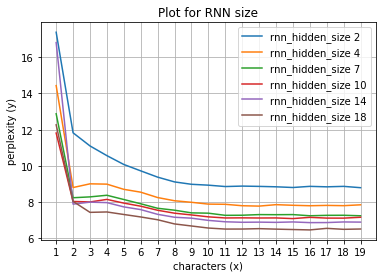

In [0]:
i = 0
plt.xlabel('characters (x)')
plt.ylabel('perplexity (y)')
plt.title('Plot for RNN size')
#print(len(allAvgPerplexities))
for avg_char_perp in allAvgPerplexities:
    plt.plot(chars,avg_char_perp, label = 'rnn_hidden_size '+str(rnn[i]))
    i +=1
    
plt.grid()
plt.xticks(np.arange(min(chars), max(chars)+1))
plt.legend()
plt.savefig("test_size_final.png")
plt.show()

##### Explanation


Rnn hidden sizes (2, 4, 7, 10, 14, 18)
1. As RNN hidden size increases, perplexity decreases. As seen in the plot, for rnn_hidden_size 18, the perplexity is the least compared to rnn hidden size 2 or 4. As the rnn hidden size increases more information is learnt. This reduces the randomness in predicting next character.

2. As we see more characters, perplexity decreases. For character at position 1 has more perplexity compared to character at 5 or 6. For example, for surname "Shanbhag" to predict 'S' has more perplexity compared to perplexity at 'b'. When predicting 'b', we would have seen more previous characters than of 'S'. So the randomness in predicting 'b' is lesser to that of 'S'. 


In [0]:
# fig, ax = plt.subplots()
# ax.plot(chars,avg_char_perp)
# ax.set(xlabel='characters (x)', ylabel='perplexity (y)',
#        title='Plot for RNN size 2')
# ax.grid()
# plt.xticks(np.arange(min(chars), max(chars)))
# fig.savefig("test_size2.png")
# plt.show()

In [0]:
# fig, ax = plt.subplots()
# ax.plot(chars,avg_char_perp)
# ax.set(xlabel='characters (x)', ylabel='perplexity (y)',
#        title='Plot for RNN size 4')
# ax.grid()
# plt.xticks(np.arange(min(chars), max(chars)))
# fig.savefig("test_size4.png")
# plt.show()

In [0]:
# fig, ax = plt.subplots()
# ax.plot(chars,avg_char_perp)
# ax.set(xlabel='characters (x)', ylabel='perplexity (y)',
#        title='Plot for RNN size 7')
# ax.grid()
# plt.xticks(np.arange(min(chars), max(chars)))
# fig.savefig("test_size7.png")
# plt.show()

In [0]:
# fig, ax = plt.subplots()
# ax.plot(chars,avg_char_perp)
# ax.set(xlabel='characters (x)', ylabel='perplexity (y)',
#        title='Plot for RNN size 10')
# ax.grid()
# plt.xticks(np.arange(min(chars), max(chars)))
# fig.savefig("test_size10.png")
# plt.show()

In [0]:
# fig, ax = plt.subplots()
# ax.plot(chars,avg_char_perp)

# ax.set(xlabel='characters (x)', ylabel='perplexity (y)',
#        title='Plot for RNN size 14')
# ax.grid()
# plt.xticks(np.arange(min(chars), max(chars)))
# fig.savefig("test_size14.png")
# plt.show()

In [0]:
# fig, ax = plt.subplots()
# ax.plot(chars,avg_char_perp)
# ax.set(xlabel='characters (x)', ylabel='perplexity (y)',
#        title='Plot for RNN size 18')
# ax.grid()
# plt.xticks(np.arange(min(chars), max(chars)))
# fig.savefig("test_size18.png")
# plt.show()